## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import os

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [28]:

train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=True)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=True)

In [29]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [30]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [34]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(TinyNeuralNetwork, self).__init__()

        NN = 256
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
                  
            nn.Linear(256, NN),
            nn.BatchNorm1d(NN),
            nn.ReLU(),
            nn.Dropout(0.4),
                              
            nn.Linear(NN, NN),
            nn.BatchNorm1d(NN),
            nn.ReLU(),
            
            nn.Linear(NN, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for img, lbl in train_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        opt.zero_grad()
        outputs = model(img)
        loss = loss_func(outputs, lbl)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == lbl).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)

    model.eval()
    test_correct = 0

    for img, lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == lbl).sum().item()

    test_accuracy = test_correct / len(fmnist_dataset_test)

print("Train Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".\
          format(train_loss,train_accuracy,test_accuracy))


Train Loss: 0.2956, Train Accuracy: 0.8912, Test Accuracy: 0.8857


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

[ 5] Train Loss: 0.2806, Train Accuracy: 0.8962, Test Accuracy: 0.8639
[10] Train Loss: 0.2183, Train Accuracy: 0.9161, Test Accuracy: 0.8879
[15] Train Loss: 0.1767, Train Accuracy: 0.9322, Test Accuracy: 0.8881
[20] Train Loss: 0.1440, Train Accuracy: 0.9448, Test Accuracy: 0.8975


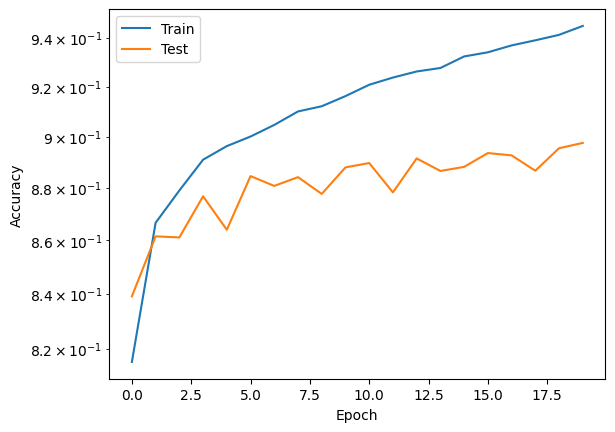

In [44]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        NN = 256
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Training loop
num_epochs = 20
trn_acc_arr = []
tst_acc_arr = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)

    trn_acc_arr.append(train_accuracy)

    model.eval()
    test_correct = 0

    for img, lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == lbl).sum().item()

    test_accuracy = test_correct / len(fmnist_dataset_test)
    tst_acc_arr.append(test_accuracy)

    if epoch%5 == 4:
        print("[{:2d}] Train Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".\
            format(epoch+1,train_loss,train_accuracy,test_accuracy))

plt.semilogy(trn_acc_arr, label='Train')
plt.semilogy(tst_acc_arr, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

[ 5] Train Loss: 0.4131, Train Accuracy: 0.8495, Test Accuracy: 0.8658
[10] Train Loss: 0.3676, Train Accuracy: 0.8653, Test Accuracy: 0.8730
[15] Train Loss: 0.3379, Train Accuracy: 0.8745, Test Accuracy: 0.8822
[20] Train Loss: 0.3207, Train Accuracy: 0.8812, Test Accuracy: 0.8845


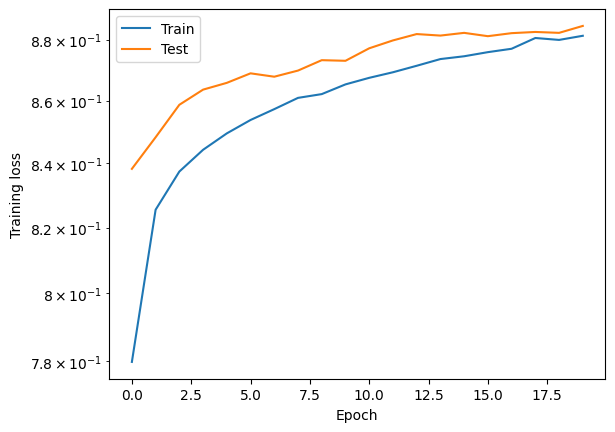

In [43]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(FixedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # Apply regularization techniques (e.g., Dropout, Batch Normalization) to reduce overfitting
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Training loop
num_epochs = 20
trn_acc_arr = []
tst_acc_arr = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    trn_acc_arr.append(train_accuracy)

    model.eval()
    test_correct = 0

    for img, lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == lbl).sum().item()

    test_accuracy = test_correct / len(fmnist_dataset_test)
    tst_acc_arr.append(test_accuracy)

    if epoch%5 == 4:
        print("[{:2d}] Train Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}".\
            format(epoch+1,train_loss,train_accuracy,test_accuracy))

plt.semilogy(trn_acc_arr, label='Train')
plt.semilogy(tst_acc_arr, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. В 1й задаче была построена линейная сеть (без сверточных слоев), которая достигает точности 0.885 на 10 эпохах
2. Во 2й задаче была построена сеть, которая на 20 эпохах существенно переучивается. Это показано на графике.
3. В 3й задаче удалось уйти от переобучения за счет применения dropout и BatchNorm